In [1]:
year = 2023
day = 10

In [2]:
import math

from aocd import submit
from aocd.models import Puzzle
import numpy as np
puzzle = Puzzle(year=year, day=day)
# data = puzzle.examples[1].input_data

data = """7-F7-
.FJ|7
SJLL7
|F--J
LJ.LJ"""

data = puzzle.input_data


data = data.strip()
data = data.split("\n")
data = [list(line) for line in data]
data = np.array(data)
data

array([['F', '-', '|', ..., '7', '7', '7'],
       ['|', '-', '7', ..., '-', '7', '|'],
       ['F', '7', '|', ..., 'L', 'L', 'J'],
       ...,
       ['F', '.', 'J', ..., 'F', '7', '|'],
       ['|', 'F', '|', ..., 'F', '7', 'J'],
       ['J', '-', 'F', ..., '-', 'J', 'J']], dtype='<U1')

In [3]:
neighbours = {
    "|" : ((1,0), (-1,0)),
    "-" : ((0,1), (0,-1)),
    "L" : ((-1,0), (0,1)),
    "J" : ((-1,0), (0,-1)),
    "7" : ((1,0), (0,-1)),
    "F" : ((1,0), (0,1)),
}

neigh_inv = {
    value: key for key, value in neighbours.items()
}

connects = {
    (1,0): ["|", "J", "L"],
    (-1,0): ["|", "7", "F"],
    (0,1): ["-", "7", "J"],
    (0,-1): ["-", "L", "F"],
}

In [4]:
y, x = [z[0] for z in np.where(data == "S")]
y, x

(128, 36)

In [5]:
def find_start_tile(data):
    y, x = [z[0] for z in np.where(data == "S")]
    possible_s = []
    for d, vals in connects.items():
        n = data[y + d[0], x + d[1]]
        # print(d, n, vals)
        if n in vals:
            possible_s.append(d)

    possible_s = tuple(possible_s)
    return neigh_inv[possible_s]

In [7]:
def find_cycle(data):
    data = data.copy()
    s = find_start_tile(data)
    y, x = [z[0] for z in np.where(data == "S")]
    data[y, x] = s
    visited = {(y, x)}
    visited.add((y, x))

    to_visit = [(y+dy, x+dx) for dy, dx in neighbours[s]]

    last_node = (y,x)

    for z in range(50000):
        y, x = to_visit.pop()
        # print(y, x)
        for dy, dx in neighbours[data[y, x]]:

            neigh = (y + dy, x + dx)
            if neigh == last_node:
                continue

            if data[neigh] in connects[dy, dx]:
                to_visit.append(neigh)

            if neigh in visited:
                # print(neigh, visited)
                print("loop found!!")
                visited.add((y, x))
                return visited

        visited.add((y, x))
        last_node = (y,x)
    return visited

visited = find_cycle(data)

loop found!!


In [8]:
clockwise_loop = {
    "|" : ((-1,0)),
    "-" : ((0,1)),
    "L" : ((-1,0)),
    "J" : ((-1,0), (0,-1)),
    "7" : ((1,0), (0,-1)),
    "F" : ((1,0), (0,1)),
}

In [10]:
answer = len(visited) // 2
answer

6856

In [11]:
submit(answer, part="a", year=year, day=day)

aocd will not submit that answer again. At 2023-12-10 01:23:21.656801-05:00 you've previously submitted 6856 and the server responded with:
That's the right answer!  You are one gold star closer to restoring snow operations. [Continue to Part Two]


In [12]:
visited_vis = np.zeros(data.shape)
for v in visited:
    visited_vis[*v] = 1
visited_vis[*[z[0] for z in np.where(data == "S")]] = 1

In [13]:
import matplotlib.pyplot as plt

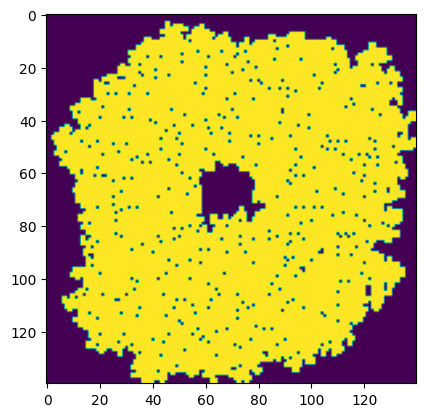

In [14]:
plt.imshow(visited_vis)

In [15]:
pipe_3x3 = {
    ".": np.array([
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
    ]),
    "F": np.array([
        [0, 0, 0],
        [0, 1, 1],
        [0, 1, 0],
    ]),
    "L": np.array([
        [0, 1, 0],
        [0, 1, 1],
        [0, 0, 0],
    ]),
    "J": np.array([
        [0, 1, 0],
        [1, 1, 0],
        [0, 0, 0],
    ]),
    "7": np.array([
        [0, 0, 0],
        [1, 1, 0],
        [0, 1, 0],
    ]),
    "|": np.array([
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
    ]),
    "-": np.array([
        [0, 0, 0],
        [1, 1, 1],
        [0, 0, 0],
    ]),
}



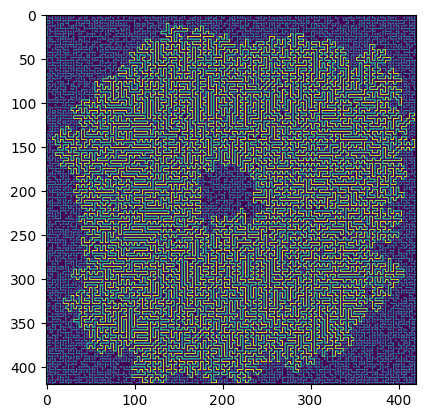

In [16]:
vis_spaced = np.zeros((data.shape[0]*3, data.shape[1]*3))

for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        if visited_vis[y, x] == 1:
            c = data[y, x]
            if c == 'S':
                c = find_start_tile(data)
            vis_spaced[y*3:(y+1)*3, x*3:(x+1)*3] = pipe_3x3[c]
        else:
            vis_spaced[y*3:(y+1)*3, x*3:(x+1)*3] = pipe_3x3[data[y, x]]*0.5

plt.imshow(vis_spaced)
plt.savefig("./path_with_unconnected.png", dpi=1000)

In [17]:
def get_neighbours(y, x, W, H):
    neighbours = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i == j == 0:
                continue
            if 0 <= x + i < W and 0 <= y + j < H:
                neighbours.append((y + j, x + i))
    return neighbours


def flood(field, y, x):
    W, H = field.shape

    visited = set()
    to_visit = {(y, x)}

    while to_visit:
        new_visit = set()
        for y, x in to_visit:
            visited.add((y, x))
            n = [(y,x) for (y, x) in get_neighbours(y, x, W, H)
                 if (not (y, x) in visited)
                 and (field[y, x] < 1)
                 ]
            new_visit.update(n)
        to_visit = new_visit

    for v in visited:
        field[*v] += 2

    field[np.where(field == 2.5)] = 0.5
    return field

vis_flooded = flood(vis_spaced.copy(), 0, 0)

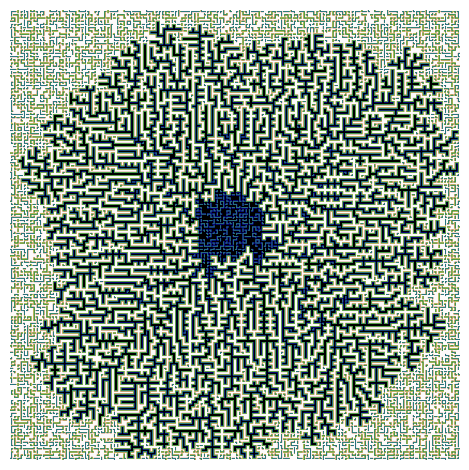

In [18]:
plt.set_cmap('gist_earth')
plt.imshow(vis_flooded)
plt.axis("off")
plt.tight_layout()
plt.savefig("./path_with_unconnected_flooded.png", dpi=1000)

In [19]:
flooded_condensed = visited_vis.copy()

for y in range(visited_vis.shape[0]):
    for x in range(visited_vis.shape[1]):
        if np.all(np.floor(vis_flooded[y*3:(y+1)*3, x*3:(x+1)*3]) == 0):
            flooded_condensed[y, x] = 3

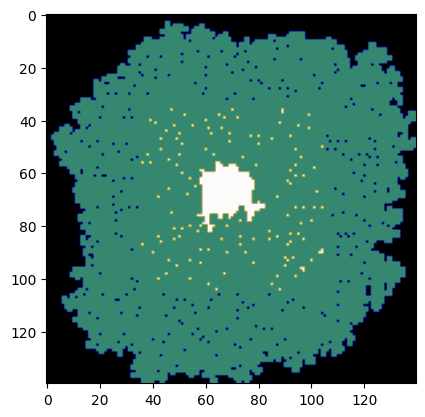

In [20]:
plt.imshow(flooded_condensed)

In [21]:
# interior = flood(visited_vis, 70, 70)
answer = np.sum(np.sum(flooded_condensed == 3))
answer

501

In [22]:
submit(answer, part="b", year=year, day=day)

coerced int64 value 501 for 2023/10


Part b already solved with same answer: 501
